In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import sys

from simplerl import (TD3Agent, 
                      TD3Net,
                      OrnsteinUhlenbeckProcess, 
                      GaussianProcess,
                      ConstantScheduler, 
                      LinearScheduler,
                      train,
                      GymMonitorHook)

%matplotlib inline

In [38]:
def plot_raw_scores(ax, monitor_hooks, window = 100):
    scores = [m.scores for m in monitor_hooks]
    min_eps_len = min([len(s) for s in scores])
    running_avgs = [pd.Series(s[:min_eps_len]).rolling(window, min_periods = 1).mean() 
                    for s in scores]
    
    for avg in running_avgs:
        ax.plot(avg)

def plot_scores(ax, monitor_hooks, window = 100):
    scores = [m.scores for m in monitor_hooks]
    min_eps_len = min([len(s) for s in scores])
    running_avgs = [pd.Series(s[:min_eps_len]).rolling(window, min_periods = 1).mean() 
                    for s in scores]
    
    average = np.array(running_avgs).mean(axis = 0)
    median = np.median(np.array(running_avgs), axis = 0)
    max_band = np.array(running_avgs).max(axis = 0)
    min_band = np.array(running_avgs).min(axis = 0)
    
    ax.plot(average, label = 'Mean Running Score')
    ax.plot(median, label = 'Median Running Score')
    ax.fill_between(np.arange(min_eps_len) + 1, 
                    min_band, max_band,
                    alpha = 0.5)

In [6]:
env_fn = lambda: gym.make('LunarLanderContinuous-v2')
model_fn = lambda: TD3Net(8, 2, (256, 128), action_scale = 1.0)
noise_fn = lambda: OrnsteinUhlenbeckProcess((2, ), ConstantScheduler(0.2))

In [8]:
monitors = []

for i in range(5):
    agent = TD3Agent(env_fn = env_fn, 
                     model_fn = model_fn,
                     n_actors = 1,
                     action_range = 1.0,
                     gamma = 0.99,
                     exploration_noise = noise_fn,
                     regularization_noise = GaussianProcess((64, 2), ConstantScheduler(0.2)),
                     noise_clip = (-0.5, 0.5),
                     batch_size = 64,
                     n_steps = 1,
                     replay_memory = 100000,
                     use_per = False,
                     replay_start = 1000,
                     parameter_tau = 1e-3,
                     buffer_tau = 1e-3,
                     optimizer = optim.Adam,
                     policy_learning_rate = 1e-4,
                     critic_learning_rate = 1e-3,
                     weight_decay = 1e-5,
                     clip_gradients = 5.0,
                     update_freq = 4,
                     policy_update_freq = 8)

    monitors.append(GymMonitorHook(verbose = 50, vector_env = True))
    
    agent.train()
    print('Training Agent {}'.format(i + 1))
    train(agent, agent.env, train_steps = 500000, hooks = [monitors[-1]], vector_env = True)
    print('')

Training Agent 1
Episode 50 | Time Steps: 111 | Average Score: -361.97
Episode 100 | Time Steps: 122 | Average Score: -468.54
Episode 150 | Time Steps: 192 | Average Score: -441.23
Episode 200 | Time Steps: 88 | Average Score: -288.99
Episode 250 | Time Steps: 170 | Average Score: -277.07
Episode 300 | Time Steps: 202 | Average Score: -273.34
Episode 350 | Time Steps: 216 | Average Score: -273.05
Episode 400 | Time Steps: 665 | Average Score: -239.19
Episode 450 | Time Steps: 483 | Average Score: -182.80
Episode 500 | Time Steps: 1000 | Average Score: -159.21
Episode 550 | Time Steps: 492 | Average Score: -128.65
Episode 600 | Time Steps: 808 | Average Score: -131.19
Episode 650 | Time Steps: 444 | Average Score: -162.04
Episode 700 | Time Steps: 1000 | Average Score: -141.38
Episode 750 | Time Steps: 971 | Average Score: -127.80
Episode 800 | Time Steps: 1000 | Average Score: -121.47
Episode 850 | Time Steps: 163 | Average Score: -83.62
Episode 900 | Time Steps: 645 | Average Score: 1

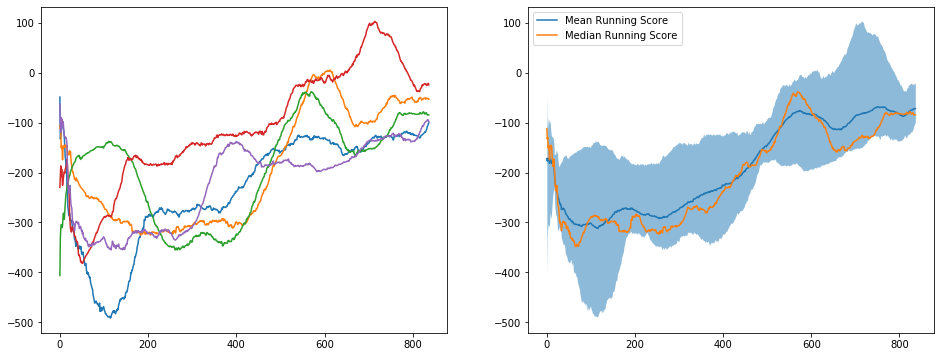

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_raw_scores(ax[0], monitors)
plot_scores(ax[1], monitors)
plt.legend(loc = 'upper left')
plt.show()

In [9]:
monitors = []

for i in range(5):
    agent = TD3Agent(env_fn = env_fn, 
                     model_fn = model_fn,
                     n_actors = 16,
                     action_range = 1.0,
                     gamma = 0.99,
                     exploration_noise = noise_fn,
                     regularization_noise = GaussianProcess((64, 2), ConstantScheduler(0.2)),
                     noise_clip = (-0.5, 0.5),
                     batch_size = 64,
                     n_steps = 5,
                     replay_memory = 100000,
                     use_per = True,
                     alpha = 0.6,
                     beta = LinearScheduler(0.4, 1.0, 100000),
                     replay_start = 1000,
                     parameter_tau = 1e-3,
                     buffer_tau = 1e-3,
                     optimizer = optim.Adam,
                     policy_learning_rate = 1e-4,
                     critic_learning_rate = 1e-3,
                     weight_decay = 1e-5,
                     clip_gradients = 5.0,
                     update_freq = 4, 
                     policy_update_freq = 8)

    monitors.append(GymMonitorHook(verbose = 50, vector_env = True))
    
    agent.train()
    print('Training Agent {}'.format(i + 1))
    train(agent, agent.env, train_steps = 250000, hooks = [monitors[-1]], vector_env = True)
    print('')

Training Agent 1
Episode 50 | Time Steps: 77 | Average Score: -223.29
Episode 100 | Time Steps: 236 | Average Score: -217.11
Episode 150 | Time Steps: 216 | Average Score: -203.72
Episode 200 | Time Steps: 1000 | Average Score: -138.90
Episode 250 | Time Steps: 499 | Average Score: -6.20
Episode 300 | Time Steps: 438 | Average Score: 114.03
Episode 350 | Time Steps: 410 | Average Score: 182.65
Episode 400 | Time Steps: 306 | Average Score: 211.98
Episode 450 | Time Steps: 402 | Average Score: 223.65
Episode 500 | Time Steps: 290 | Average Score: 215.20
Episode 550 | Time Steps: 246 | Average Score: 213.64
Episode 600 | Time Steps: 265 | Average Score: 222.08
Episode 650 | Time Steps: 320 | Average Score: 219.37
Episode 700 | Time Steps: 282 | Average Score: 211.54
Episode 750 | Time Steps: 989 | Average Score: 202.31
Episode 754 | Time Steps: 85 | Average Score: 201.87

Training Agent 2
Episode 50 | Time Steps: 94 | Average Score: -166.16
Episode 100 | Time Steps: 116 | Average Score: 

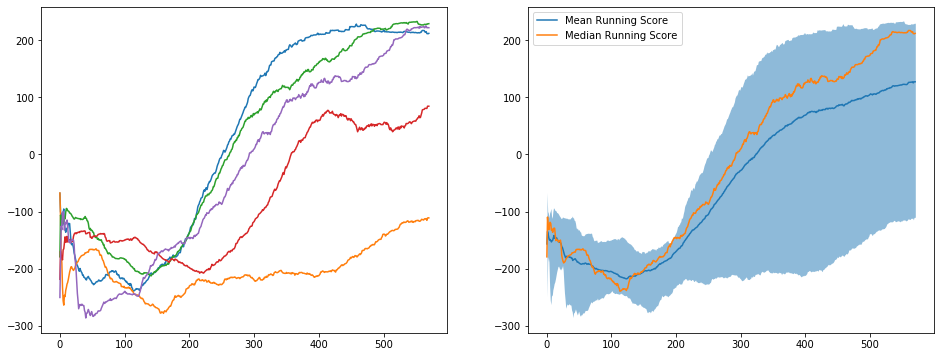

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))
plot_raw_scores(ax[0], monitors)
plot_scores(ax[1], monitors)
plt.legend(loc = 'upper left')
plt.show()